In [1]:
# Initialize libraries and load data
"""
Created on Wed Mar  4 02:08:22 2020

@author: stjepan
"""
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


sbox=(
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16) 

hamming = [bin(n).count("1") for n in range(256)]

def cov(x, y):
    return np.cov(x, y)[0][1]

def intermediate(pt, keyguess):
    return sbox[pt ^ keyguess]

traces = np.load(r'chipwhisperer\traces.npy')
pt = np.load(r'chipwhisperer\plain.npy')
knownkey = np.load(r'chipwhisperer\key.npy')

In [2]:
def attackSubKey(pooled=False, nProfilingTraces = 9000, nAttackTraces = 10, key=0, numFeatures = 10):
    tracesTrain = traces[0:nProfilingTraces]
    ptTrain  = pt[0:nProfilingTraces]

    tracesTest = traces[10000 - nAttackTraces:10000]
    ptTest  = pt[10000 - nAttackTraces:10000]

    outputSbox = [intermediate(ptTrain[i][key], knownkey[i][key]) for i in range(len(ptTrain))] 

    Traces = [[] for _ in range(256)]

    for i in range(len(tracesTrain)):
        v = outputSbox[i]
        Traces[v].append(tracesTrain[i])
    
    Traces = [np.array(Traces[i]) for i in range(256)]

    Means = np.zeros((256, len(tracesTrain[0])))
    for i in range(256):
        Means[i] = np.average(Traces[i], 0)

    SumDiff = np.zeros(len(tracesTrain[0]))
    for i in range(256):
        for j in range(i):
            SumDiff += np.abs(Means[i] - Means[j])

    features = []
    featureSpacing = 5
    for i in range(numFeatures):
        nextFeature = SumDiff.argmax()
        features.append(nextFeature)

        featureMin = max(0, nextFeature - featureSpacing)
        featureMax = min(nextFeature + featureSpacing, len(SumDiff))
        for j in range(featureMin, featureMax):
            SumDiff[j] = 0

    meanMatrix = np.zeros((256, numFeatures))
    covMatrix  = np.zeros((256, numFeatures, numFeatures))

    for intermediate_val in range(256):
        for i in range(numFeatures):
            meanMatrix[intermediate_val][i] = Means[intermediate_val][features[i]]
            for j in range(numFeatures):
                x = Traces[intermediate_val][:,features[i]]
                y = Traces[intermediate_val][:,features[j]]
                covMatrix[intermediate_val,i,j] = cov(x, y)

    key_rank = np.zeros(16)
    P_k = np.zeros(256)
    if(pooled):
        pooled_cov = np.average(covMatrix, axis=0) #take average cov matrix for all possible intermediate values
    ranks = np.zeros(len(tracesTest))
    for j in range(len(tracesTest)):
        a = [tracesTest[j][features[i]] for i in range(len(features))]

        for kguess in range(0, 256):
            intermediate_res = intermediate(ptTest[j][key], kguess)
            if(pooled):
                rv = multivariate_normal(meanMatrix[intermediate_res], pooled_cov) #pooled cov matrix
            else:
                rv = multivariate_normal(meanMatrix[intermediate_res], covMatrix[intermediate_res])
            p_kj = rv.pdf(a)
            P_k[kguess] += np.log(p_kj)

#         print (P_k.argsort()[-15:])    
#         tarefs = np.argsort(P_k)[::-1]
        res = np.argmax(np.argsort(P_k)[::-1] == knownkey[key][key]) #get pos of correct key guess
        ranks[j] = res
    return np.average(ranks, 0)

def runExperiment(pooled=False, nProfilingTraces = 9000, nAttackTraces = 10, numFeatures = 20):
    res = np.zeros(16)
    for i in range(16):
        res[i] = (attackSubKey(pooled=pooled, nProfilingTraces = nProfilingTraces, nAttackTraces = nAttackTraces, key=i, numFeatures = numFeatures))
        
    return(np.sum(res, 0))



9000


<ipython-input-2-328101a75c66>:64: RuntimeWarning: divide by zero encountered in log
  P_k[kguess] += np.log(p_kj)


9100
9200
9300
9400
9500
9600
9700
9800
9900


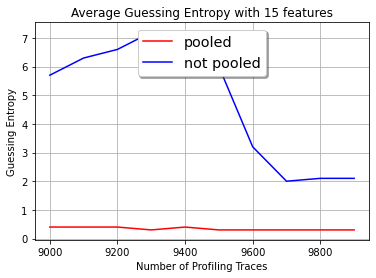

In [11]:
def plot_traces_vs_GE(numFeatures = 10):
    num_traces = []
    GE = []
    pooled_GE = []
    for i in range(90, 100):
        nProfilingTraces = i*100
        print(nProfilingTraces)
        num_traces.append(nProfilingTraces)
        GE.append(runExperiment(pooled=False, nProfilingTraces = nProfilingTraces, numFeatures = numFeatures))
        pooled_GE.append(runExperiment(pooled=True, nProfilingTraces = nProfilingTraces, numFeatures = numFeatures))

    plt.plot(num_traces, pooled_GE, 'r', label='pooled') 
    plt.plot(num_traces, GE, 'b', label='not pooled') 
    plt.legend(loc='upper center', shadow=True, fontsize='x-large')
    plt.xlabel('Number of Profiling Traces')
    plt.ylabel('Guessing Entropy')
    plt.title('Average Guessing Entropy with {} features'.format(numFeatures))
    plt.grid()
    plt.show()

# plot_traces_vs_GE(10)
plot_traces_vs_GE(15)